### Please do the setup right (https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/) before executing this script
### This script uses https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/auto_examples/plot_object_detection_saved_model.html.
This script does the inference of a object detection model (with tensoflow api).
This script is intended to be executed on colab (Pro).
The output of the code was not part of the bachelor thesis of Max Dietsch

In [ ]:
# the following installations are not on every system neccesary.
!pip install tf-nightly-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 577.5 MB 7.2 kB/s 
     |████████████████████████████████| 1.7 MB 67.1 MB/s 
     |████████████████████████████████| 5.8 MB 44.2 MB/s 
     |████████████████████████████████| 438 kB 55.3 MB/s 
  Attempting uninstall: keras-nightly
    Found existing installation: keras-nightly 2.5.0.dev2021032900
    Uninstalling keras-nightly-2.5.0.dev2021032900:
      Successfully uninstalled keras-nightly-2.5.0.dev2021032900
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.1 requires flatbuffers<2,>=1.12, but you have flatbuffers 2.0 which is incompatible.


In [ ]:
!pip uninstall -y tensorflow keras tf-nightly keras-nightly

Found existing installation: tensorflow 2.9.1
Uninstalling tensorflow-2.9.1:
  Successfully uninstalled tensorflow-2.9.1
Found existing installation: keras 2.9.0
Uninstalling keras-2.9.0:
  Successfully uninstalled keras-2.9.0
Found existing installation: keras-nightly 2.10.0.dev2022063007
Uninstalling keras-nightly-2.10.0.dev2022063007:
  Successfully uninstalled keras-nightly-2.10.0.dev2022063007


In [ ]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-2.9.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511.7 MB)
  Using cached keras-2.9.0-py2.py3-none-any.whl (1.6 MB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-nightly-gpu 2.10.0.dev20220630 requires keras-nightly~=2.10.0.dev, which is not installed.
tf-nightly-gpu 2.10.0.dev20220630 requires flatbuffers>=2.0, but you have flatbuffers 1.12 which is incompatible.


In [ ]:
import io
import os
import scipy.misc
import numpy as np
import six
import time
import glob
from IPython.display import display

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

%matplotlib inline

AttributeError: ignored

In [ ]:
# load image in numpy array
def load_image_into_numpy_array(path):
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  if image.mode == 'RGBA':
    image = image.convert('RGB')
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [ ]:
# useful, so that labels are on the detections
labelmap_path = "annotations/label_map.pbtxt"
category_index = label_map_util.create_category_index_from_labelmap(labelmap_path, use_display_name=True)

NameError: ignored

In [ ]:
# get a model from drive
%mkdir exported-models
%cp -r ../../drive/MyDrive/efficient_exported-models/* ./exported-models

mkdir: cannot create directory ‘exported-models’: File exists


In [ ]:
# load the model 
tf.keras.backend.clear_session()
model = tf.saved_model.load("exported-models/saved_model")

In [ ]:
# runs inference of a model
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks, only neccesary for image segmentation:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

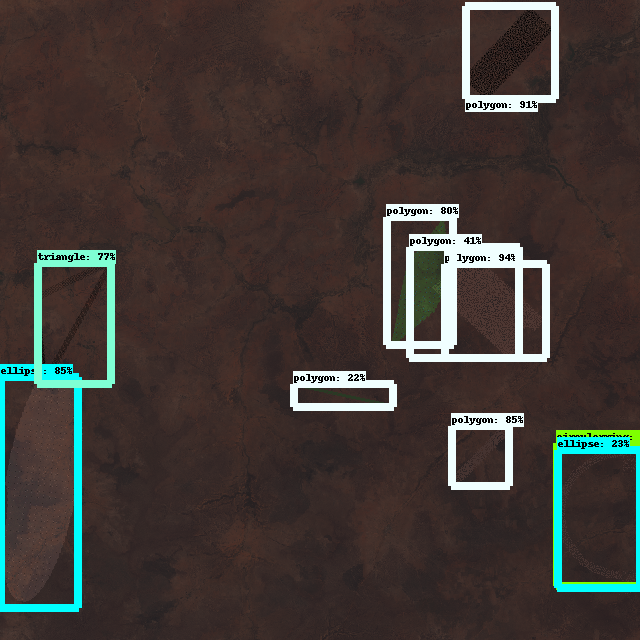

In [ ]:
# run inference on several images and show the results
# min_score_thresh can be modified so that only detection above a certain score are shown
# decrease line_thickness to get smaller bounding boxes
i = 0
for image_path in glob.glob('images/test/*.png'):
  #if i > 10:
   # break
  image_np = load_image_into_numpy_array(image_path)
  output_dict = run_inference_for_single_image(model, image_np)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8,
      min_score_thresh=.15)
  display(Image.fromarray(image_np))
  im = Image.fromarray(image_np)
  im.save('../../drive/MyDrive/test/' + str(i) + ".png")
  im.save('images/train/' + str(i) + ".png")

  i = i + 1